# Perception

<a href="https://colab.research.google.com/github/gtbook/robotics/blob/main/S24_sorter_perception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q -U gtbook

Note: you may need to restart the kernel to use updated packages.


In [2]:
from ipywidgets import interact
import numpy as np
import pandas as pd
import gtsam

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
try:
    import google.colab
except:
    import plotly.io as pio
    pio.renderers.default = "png"

import gtbook
from gtbook.display import show
from gtbook.discrete import Variables
VARIABLES = Variables()
def pretty(obj): 
    return gtbook.display.pretty(obj, VARIABLES)

In [3]:
# Define variables here
Conductivity = VARIABLES.binary("Conductivity")
Detection = VARIABLES.discrete("Detection", ["bottle", "cardboard", "paper"])
categories = ["cardboard", "paper", "can", "scrap metal", "bottle"]
Category = VARIABLES.discrete("Category", categories) # Not an accident that it is defined last.

```{index} perception
```
> Perception is the process of turning sensor measurements in actionable information.

<img src="Figures2/S24-Trash_sorting_robot_with_gripper-02.jpg" alt="Splash image with robot sporting big eyes" width="40%" align=center style="vertical-align:middle;margin:10px 0px">

In the previous section we learned about how to *model* sensors, and how to simulate sensors at work. In this section we want to invert that process: when given one or more measurements, *infer* what the state might be.
As in the previous section, because sensors are not deterministic devices, this inference process will not produce a definitive result, but will at best yield a probability distribution over possible states,
given the sensor reading. 

In this section, we build up the mathematical machinery for this inference process, beginning with likelihoods, and working our way to full probability distributions that are obtained by fusing data from multiple sensors.

```{index} perception; maximum likelihood
```
## Maximum Likelihood

> Maximum likelihood estimation outputs the state that "agrees" most with the measurement.

Let us revisit the weight sensor from the previous section as an example. We first redefine it in code:

In [4]:
def Gaussian(x, mu=0.0, sigma=1.0):
    return np.exp(-0.5*(x-mu)**2/sigma**2)/np.sqrt(2*np.pi*sigma**2)
# Conditional weight density, mean and standard deviation specified in in grams:
pWC = np.array([[20, 10], [5, 5], [15, 5], [150, 100], [300, 200]])

Now, suppose an unknown object enters the sorting area, and the weight sensor outputs *50 grams*. What state is the most *likely*, given this measurement? One idea is to simply check the conditional probability $p(\text{Weight}=50|\text{Category})$ value for each of the possible categories. The following piece of code does that for our example:

In [5]:
for index, category in enumerate(categories):
    mu, sigma = pWC[index]
    print(f"{category:12}:{Gaussian(50, mu, sigma):.5f}")

cardboard   :0.00044
paper       :0.00000
can         :0.00000
scrap metal :0.00242
bottle      :0.00091


In the code above, we `enumerate` all possible categories, and use the `index` to pick out the parameters of the corresponding conditional Gaussian density. Then we just print it nicely.

```{index} pair: maximum likelihood estimate; ML estimate
```
We can see that choosing the `scrap metal` category for the state would accord the highest conditional probability value to the measurement $weight=50$. We say that `scrap metal` is the **maximum likelihood estimate** or **ML estimate**  $x^*_{ML}$ of the category $X$ given the measurement $z$. Formally, we define it as
\begin{equation}
x^*_{ML} \doteq \arg \max_x p(Z=z|X=x).
\end{equation}
In other words, we vary the *state* $X$ in the conditional probability while keeping the measurement $Z$ fixed, with known value $z$, and then select the $X$ that maximizes the resulting number.

```{index} likelihood, likelihood function
```
## The Likelihood Function
> Likelihoods are not probabilities.

It is convenient to define the **likelihood** of a state $X$ given the measurement $z$ as any function $L(X;z)$ that is proportional to the conditional density $p(z|X)$:
\begin{equation}
L(X;z) \propto p(z|X).
\end{equation}
The notation above emphasizes that the measurement $z$ is given, and that the likelihood is a function defined on the state $X$. This is something many people get confused about. It is the *state* that is likely or unlikely, not the measurement.

Because of the definition above, the maximum likelihood estimate $x^*_{ML}$ is equivalently obtained as
\begin{equation}
x^*_{ML} \doteq \arg \max_x L(X=x;z).
\end{equation}
Note that the value $x^*$ that maximizes the value of a function $f(x)$
also maximizes the value of the function $\alpha f(x)$ for any constant $\alpha > 0$,
and therefore maximizing $p(z|X)$ is equivalent to maximizing $L(X=x;z)$.
This is a theme we will encounter quite often: when maximizing (or minimizing) a quantity, we will often not be so concerned with the proportionality constants, which can be expensive to compute.

In Figure [1](#fig:likelihood_given_weight) we define the likelihood function in code and plot it.
As you can see, when we have a set of discrete categories, even a *continuous* sensor measurement will induce a *discrete* likelihood function.
The plot also shows clearly that some categories are more likely than others, and that for a weight of $50g$, `scrap metal` is the maximum likelihood estimate.

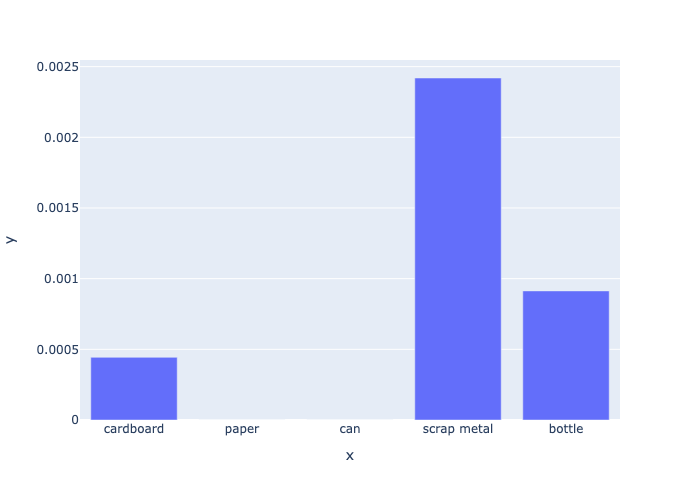

In [6]:
#| caption: Likelihood of observing a weight of 50g as a function of category.
#| label: fig:likelihood_given_weight
def likelihood_given_weight(weight):
    return np.array([Gaussian(weight, *pWC[index]) for index in range(5)])
L50 = likelihood_given_weight(weight=50)
px.bar(y=L50, x=categories)

It is crucial to understand that the likelihood function $L(X;z)$ is itself *not* a probability distribution over the state $X$. Indeed, if we take the example from above and add the numbers, we get the following:

In [7]:
print(f"sum(L)={sum(L50):.5f}")

sum(L)=0.00378


Since probabilities always sum to one, the likelihood function is clearly not a probability distribution.

## Exploring the Likelihood

With some python notebook magic in Figure [2](#fig:interactive_likelihood), we can create a fully interactive applet to explore how the likelihood function changes for different outcomes of the measurement.

In [8]:
def likelihood_figure(weight):
    """Complicated figure to show likelihood for continuous case."""
    X = np.arange(0, 500)
    fig = make_subplots(
        rows=5, cols=2,
        column_widths=[0.6, 0.4],
        row_heights=[0.2, 0.2, 0.2, 0.2, 0.2],
        specs=[[{"type": "xy"}, {"type": "bar", "rowspan": 5}],
               [{"type": "xy"}, None],
               [{"type": "xy"}, None],
               [{"type": "xy"}, None],
               [{"type": "xy"}, None],
               ]
    )

    for index, category in enumerate(categories):
        fig.add_trace(
            go.Scatter(x=X, y=Gaussian(X, *pWC[index]), name=category),
            row=index+1, col=1
        )

    L = likelihood_given_weight(weight)
    fig.add_trace(go.Bar(x=L[::-1], y=categories[::-1], orientation="h",
                  name="Likelihood"), row=1, col=2)
    return fig


In [9]:
#| caption: Interactive plot showing the likelihood.
#| label: fig:interactive_likelihood
@interact(weight=(0, 500, 5))
def show_likelihood(weight=50):
    display(likelihood_figure(weight))

interactive(children=(IntSlider(value=50, description='weight', max=500, step=5), Output()), _dom_classes=('wi…

Playing with this interactive applet gives some insight in how the likelihood behaves, and how the ML estimate shifts between categories as the weight measurement changes. We can actually capture this in one convenient graph, by plotting the *normalized* likelihood function against weight on the x-axis, shown in Figure [3](#fig:normalized_likelihood).

In [10]:
def normalized(x):
    Lx = likelihood_given_weight(x)
    return Lx/np.sum(Lx)
X = np.arange(0.0,300)
Y = np.array([normalized(x) for x in X])

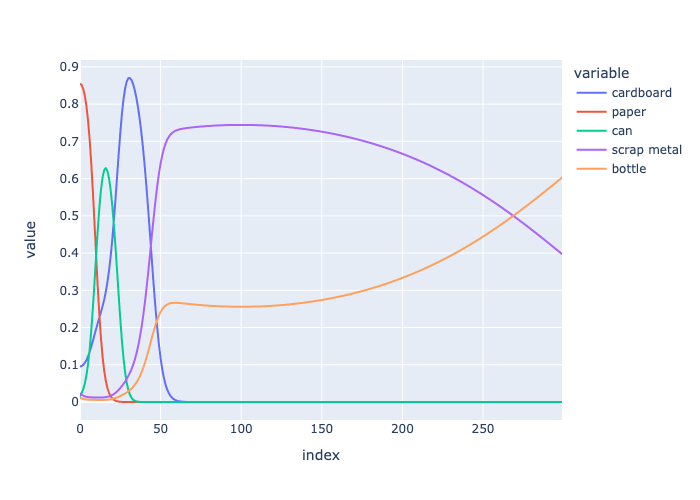

In [11]:
#| caption: Normalized likelihood for different weights and categories.
#| label: fig:normalized_likelihood
df = pd.DataFrame(data=Y, index=X, columns=categories, )
px.line(df, )

```{index} decision boundary
```
In the figure you can see that, as the weight increases, the maximum likelihood category changes respectively from `paper` to `can` to `cardboard`, then `scrap metal` wins out for a long interval between approx. $45g$ and $270g$, after which finally `bottle` becomes the MLE above $270g$. The transition points are known as **decision boundaries**, and represent the locations in measurement space where our ML estimator changes its estimate.

Note: we will see below that normalizing as we did here corresponds to assuming we have no *a priori* knowledge about the category distribution, which is of course incorrect for our trash sorting example.

## Likelihood with Discrete Sensors
Of course, we can also define the likelihood of the category given the output of a discrete sensor. 
For example, let us redefine the "detector" sensor model from the previous section. First, as before, we model it using a conditional probability distribution:

In [12]:
pDT = gtsam.DiscreteConditional(
    Detection, [Category], "2/88/10 2/20/78 33/33/34 33/33/34 95/2/3")
pretty(pDT)

Category,bottle,cardboard,paper
cardboard,0.02,0.88,0.1
paper,0.02,0.2,0.78
can,0.33,0.33,0.34
scrap metal,0.33,0.33,0.34
bottle,0.95,0.02,0.03


After that, the likelihood functions correspond to the *columns* above: one column for each possible detection outcome. Again, note that these likelihood functions do *not* sum to 1.0; *the rows sum up to 1.0, but the columns do not*.

## Likelihood Factors
> We can use a *factor* to represent the likelihood of an unknown state.

All of the perception algorithms in this book will heavily depend on likelihood functions, and we now
introduce a special data structure to conveniently represent them in code. For the Gaussian measurement model, we can instantiate a `DecisionTreeFactor` with the likelihood function we calculated above for the weight sensor:

In [13]:
weight_50_factor = gtsam.DecisionTreeFactor(
    Category, likelihood_given_weight(50))
pretty(weight_50_factor)


Category,value
cardboard,0.000443185
paper,2.05595e-19
can,1.82694e-12
scrap metal,0.00241971
bottle,0.000913245


```{index} factor, likelihood factor
```
Formally, a **factor** $\phi(X)$ is simply a function from outcomes $x$ to the real numbers,
and hence we can use it to represent the likelihood of all possible outcomes, given a measurement $z$. When used in this way, we call $\phi$ a **likelihood factor** and we make the dependence on $z$ explicit
by writing 
\begin{equation}
\phi(X; z)
\end{equation}
in analogy with the likelihood function $L(X; z)$. To distinguish likelihood factors derived from different sensors, we  use a subscript, e.g., the weight-derived likelihood factor we derived above might be written like so:
\begin{equation}
\phi_w(\text{Category}; \text{Weight}=50)
\end{equation}

Let us now define the likelihood factor $\phi(\text{Category}; \text{Detection})$ for the discrete detection factor. In GTSAM, a `DiscreteConditional` class actually has a handy `likelihood` method by which we can pick out the column. e.g., corresponding to the `cardboard` detection:

In [14]:
detector_outcomes = ["bottle", "cardboard", "paper"]
index = detector_outcomes.index("cardboard")  # 1 is the index for "cardboard"
detected_cardboard_factor = pDT.likelihood(index)
pretty(detected_cardboard_factor)

Category,value
cardboard,0.88
paper,0.2
can,0.33
scrap metal,0.33
bottle,0.02


[Figure 4](#fig:likelihood_given_detection) shows a small interactive applet that allows us to examine the likelihood factor for every possible detection outcome. Note that we use the built-in `index` function to translate detection outcomes to an integer index:

In [15]:
#| caption: The likelihood of observing a category given a detection.
#| label: fig:likelihood_given_detection
@interact(detection=detector_outcomes)
def show_likelihood(detection="bottle"):
    index = detector_outcomes.index(detection)
    L_index = [v for (k,v) in pDT.likelihood(index).enumerate()]
    display(px.bar(x=L_index, y=categories))

interactive(children=(Dropdown(description='detection', options=('bottle', 'cardboard', 'paper'), value='bottl…

Picking out the most *likely* category only gets us so far, however: it is not clear how we might fuse multiple sensor measurements, or how to incorporate prior information. In fact, we can do better... we can use Bayes’ theorem to accomplish both goals. We will do so below, after first explaining the concept of *joint distributions*.

```{index} joint probability distribution, chain rule
```
## Joint Distribution

> A joint probability distribution allows us to calculate the probability of two or more variables co-occurring.

Let us consider again a sensor model $P(X|Z)$, where until now we viewed the variable $Z$ as a parameter. If we instead treat the parameter $Z$ not as a *known* parameter but as an unknown variable itself, with probability distribution $P(Z)$, we obtain a **joint probability distribution** over the pair of variables $X$ and $Z$, and its PMF is
given by the **chain rule**:
\begin{equation}
P(X,Z)=P(X|Z)P(Z)
\end{equation}

To sample from a joint distribution $P(X,Z)$, we first sample a value $z$ from $P(Z)$, as it does not depend on
any other variable, and then sample a value $x$ from the conditional
distribution $P(X|z)$.

As an example, let us calculate the joint probability of `Detection` and `Conductivity`:

In [16]:
pCT = gtsam.DiscreteConditional(
    Conductivity, [Category], "99/1 99/1 10/90 15/85 95/5")
category_prior = gtsam.DiscreteDistribution(Category, "200/300/250/200/50")
joint = pCT * category_prior
pretty(joint)

Conductivity,Category,value
false,cardboard,0.198
false,paper,0.297
false,can,0.025
false,scrap metal,0.03
false,bottle,0.0475
true,cardboard,0.002
true,paper,0.003
true,can,0.225
true,scrap metal,0.17
true,bottle,0.0025


The table above is the result of applying the chain rule
\begin{equation}
P(\text{Conductivity},\text{Category}) = P(\text{Conductivity}|\text{Category}) P(\text{Category})
\end{equation}
and contains $10=2*5$ entries. A quick check validates that all entries sum up to $1.0$, i.e., this is truly a probability distribution over the *product space* $\{\text{True}, \text{False}\} \times \{\text{cardboard}, \text{paper}, \text{can}, \text{scrap metal}, \text{bottle}\}$:

In [17]:
assert sum(p for _, p in joint.enumerate()) == 1.0

```{index} marginal probability distribution
```
## Marginal Distributions

> We can *project* a joint distribution onto its individual variables.

Given a joint probability distribution $P(X,Z)$ for discrete random
variables $X$ and $Z$, we can determine the probability
of an outcome $x$ for $X$, irrespective of the value of $Z$. We call
this the **marginal probability distribution** of $X$, and it can be
calculated as
\begin{equation}
P(X)=\sum_{z}P(X,Z=z)
\end{equation}
and of course we can also calculate the
marginal distribution of $Z$, in the same way: 
\begin{equation}
P(Z)=\sum_{x}P(X=x,Z)
\end{equation}

GTSAM has built-in functions to project joint distributions onto their marginals. For example, if we calculate the marginal $P(\text{Category})$ we simply get the prior on `Category` back:

In [18]:
pCat = joint.marginal(Category[0]) # Note marginal takes an id, not a tuple
pretty(pCat)

Category,value
cardboard,0.2
paper,0.3
can,0.25
scrap metal,0.2
bottle,0.05


However, if we *marginalize* to the `Conductivity` variable, we instead recover the probabilities that the conductivity sensor will return `True` or `False`, *regardless* of the category. We see that in about $60\%$ of the cases the conductivity sensor should return `False`:

In [19]:
pCon = joint.marginal(Conductivity[0]) # Note marginal takes an id, not a tuple
pretty(pCon) # Note marginal takes an id, not a tuple

Conductivity,value
false,0.5975
true,0.4025


We can also calculate the conditional distributions when given the joint distribution, by taking the joint probability distribution and dividing by the appropriate marginal (assuming those are non-zero!):
\begin{equation}
\begin{aligned}
P(X|Z) & =P(X,Z)/P(Z)\\
P(Z|X) & =P(X,Z)/P(X)
\end{aligned}
\end{equation}
This is really just the chain rule, rearranged.

In code, this is implemented by a special constructor for `DiscreteConditional`, taking joint and marginal
distributions, respectively. For example, the following piece of code recovers our conductivity sensor model from the joint distribution, by implementing
\begin{equation}
P(\text{Conductivity}|\text{Category}) = \frac{P(\text{Category},\text{Conductivity})}{P(\text{Category})}
\end{equation}

In [20]:
p_Conductivity_given_Category = gtsam.DiscreteConditional(joint, pCat)
pretty(p_Conductivity_given_Category)

Category,false,true
cardboard,0.99,0.01
paper,0.99,0.01
can,0.1,0.9
scrap metal,0.15,0.85
bottle,0.95,0.05


```{index} Bayes’ Theorem
```
## Bayes’ Theorem

> Bayes’ theorem says that the posterior is the likelihood times the prior.

Given the formulas we discussed above, we can now derive Bayes’ theorem,
which allows us to infer knowledge about a variable, say the robot state
$X$, given an observed sensor value $z$. The theorem is named after the
Reverend Thomas Bayes, an eighteenth century minister who took an
interest in probability later in life. He also lends his name to the
Bayes nets that we discuss in the next chapter.

Bayes’ theorem allows us to calculate the **posterior probability
distribution** $P(X|Z=z)$ on the variable $X$ given an observed value
for $Z$. When applying Bayes’ theorem we use the term “prior” to indicate knowledge we
have about a variable $X$ before seeing evidence for it, and use the term
"posterior" to denote the knowledge after having incorporated evidence.
In our case, the evidence is the observed value $z$. To calculate the
posterior, the elements we need are a prior probability distribution
$P(X)$, a conditional probability distribution $P(Z|X)$ modeling the
measurement, and the value $z$ itself. Given these elements, we can
calculate the posterior probability distribution on $X$:
\begin{equation}
P(X|Z=z)=\frac{P(Z=z|X)P(X)}{P(Z=z)}
\end{equation}
 The proof is simple and involves applying the chain rule in two ways:
\begin{equation}
P(Z|X)P(X)=P(X,Z)=P(X|Z)P(Z).
\end{equation}

As we have already seen, because the observation is *known*, we can use the 
definition of the likelihood function $L(X;z)\propto P(Z=z|X)$
and substitute that into the expression above.
In addition, note that above the quantity $P(Z=z)$ simply acts as a normalization constant. Given
these two facts, we can state Bayes’ theorem in a more intuitive, and
easier to remember way as
\begin{equation}
P(X|Z=z)\propto L(X;z)P(X)
\end{equation}
 or *"the posterior is proportional to the likelihood weighted by the prior."*

Finally, when actually computing a posterior there is not even a need to think about anything but the joint distribution. Indeed, because by the chain rule we have $P(Z=z|X)P(X)=P(X,Z=z)$, and because $P(Z=z)$ is just a normalization factor, we obtain a *third* form of Bayes’ theorem, which
is the simplest of all:
\begin{equation}
P(X|Z=z)\propto P(X,Z=z)
\end{equation}
Hence, if we are
given a formula or table of joint probability entries $P(X,Z)$, it
suffices to just select all entries for which $Z=z,$ normalize, and voilà!

```{index} pair: maximum a posteriori; MAP
```
```{index} perception; MAP estimate
```
```{index} hidden state
```

## MAP Estimation
> We combine likelihoods with the prior into a posterior, via Bayes’ theorem.

We are now finally in a position to optimally calculate everything we know about a "hidden" state $X$, given and observed sensor measurement $z$. In GTSAM, we simply combine a likelihood factor $\phi(X; z)$ with a prior $P(X)$ on the unknown variable $X$. This immediately yields a probability distribution over all category `detector_outcomes`.

The **maximum a posteriori** or **MAP** estimate $x^*_{MAP}$ for the variable $X$ is the value which maximizes the posterior $P(X|z)$, i.e., 
\begin{equation}
x^*_{MAP} = \arg \max_x P(x|z) = \arg \max_x L(x;z) P(X)
\end{equation}

For example, let's assume that the conductivity sensor measured `False`, what is then our knowledge about `Category`? The code creates the factor, multiplies it with the prior, and displays the result as a (pretty) table:

In [21]:
conductivity_false_factor = pCT.likelihood(0)
pretty(conductivity_false_factor)

Category,value
cardboard,0.99
paper,0.99
can,0.1
scrap metal,0.15
bottle,0.95


In [22]:
unnormalized_posterior = conductivity_false_factor * category_prior
print(type(unnormalized_posterior))
print(sum(p for _, p in unnormalized_posterior.enumerate()))
pretty(unnormalized_posterior)

<class 'gtsam.gtsam.DecisionTreeFactor'>
0.5975


Category,value
cardboard,0.198
paper,0.297
can,0.025
scrap metal,0.03
bottle,0.0475


Above, we also printed out the type (a `DecisionTreeFactor`) and the sum of the product, which does not sum up to 1.0! Indeed, the product of a factor with a conditional yields another factor, which is the *unnormalized posterior*, i.e., the right-hand-side in the second form of Bayes’ theorem. 

Note that we *do not need to normalize* to see that the MAP category, given our prior knowledge and a `False` conductivity measurement is `paper`.  However, it would be nice to see the actual probability `detector_outcomes`. This can be done by normalizing, which in GTSAM is easiest by converting the factor to a `DiscreteDistribution`, like so:

In [23]:
posterior = gtsam.DiscreteDistribution(unnormalized_posterior)
print(type(posterior))
assert sum(p for _, p in posterior.enumerate()) == 1.0
pretty(posterior)

<class 'gtsam.gtsam.DiscreteDistribution'>


Category,value
cardboard,0.331381
paper,0.497071
can,0.041841
scrap metal,0.0502092
bottle,0.0794979


Now we can more easily appreciate the relative posterior probabilities. The `paper` category was already the most probable category *a priori*, at $30\%$, and the negative conductivity measurement strengthened our belief in this outcome to almost $50\%$.

In contrast, if we would have had a *positive* conductivity measurement, we would obtain a very different result:

In [24]:
Cat_given_Con1 = gtsam.DiscreteDistribution(pCT.likelihood(1) * category_prior)
assert sum(p for _, p in Cat_given_Con1.enumerate()) == 1.0
pretty(Cat_given_Con1)

Category,value
cardboard,0.00496894
paper,0.00745342
can,0.559006
scrap metal,0.42236
bottle,0.00621118


Now the `can` category is the MAP estimate, and the posterior probability for `cardboard` is almost $0\%$. The reason is because the likelihood of `paper` given positive conductivity is very low (check it!).

```{index} sensor fusion
```
## Fusing Multiple Measurements

> Bayes’ theorem can easily accommodate multiple measurements as well.

Applying Bayes’ theorem to the joint measurement $(z_z, z_2)$ gives
\begin{equation}
P(X|z_1, z_2) \propto L(X;z_1, z_2) P(X)
\end{equation}
where the likelihood function is defined as
\begin{equation}
L(X;z_1, z_2) \propto P(z_1, z_2 | X)
\end{equation}

```{index} conditionally independent, conditional independence
```
Often sensor measurements are **conditionally independent** given the state variable $X$.
Mathematically, the outcomes $Z_1$ and $Z_2$ are conditionally independent given $X$ if
\begin{equation}
P(Z_1, Z_2 | X) = P(Z_1 | X) P(Z_2 | X)
\label{eq:independence}
\end{equation}

Conditional independence often occurs when two sensors both depend on the same aspects
of the state. In such cases, when the state is not known, information about $Z_1$ might
be informative regarding possible values of $Z_2$, but once the state is known,
knowing the value of $Z_1$ will not influence our belief about what to expect for $Z_2$.

When $Z_1$ and $Z_2$ are conditionally independent given $X$,
the likelihood function *factors* into a product:
\begin{equation}
L(X;z_1, z_2) \propto L(X;z_1) L(X;z_2)
\end{equation}
Hence, Bayes’ theorem simply becomes
\begin{equation}
P(X|z_1, z_2) \propto L(X;z_1) L(X;z_2) P(X).
\end{equation}

In other words, *the posterior is proportional to the product of the likelihoods weighted by the prior*. This result generalizes to an arbitrary number of sensor measurements, *provided* they are conditionally independent given the value of the variable $X$.

```{index} statistically independent
```
It is important to note that conditional independence applies only when the value of $X$ is known. Unless the sensors are **statistically independent**, i.e., $P(Z_1, Z_2) = P(Z_1) P(Z_2)$,
if $X$ is *not* known, sensor measurements are not independent. In Equation [19](#eq:independence), the variable $X$ always appears behind the conditioning bar, which is our way of saying "given a *known* category".

As our last example in this section, given the above generalized Bayes’ theorem, we can finally *fuse* the information from the three measurements into a posterior over the category. For example, given a weight of $50g$, a `False` conductivity measurement, and the detector saying `cardboard`, we obtain the following for the likelihood,

In [25]:
likelihood = weight_50_factor * conductivity_false_factor * detected_cardboard_factor
pretty(likelihood)

Category,value
cardboard,0.000386103
paper,4.07079e-20
can,6.02892e-14
scrap metal,0.000119776
bottle,1.73517e-05


{raw:tex}`\noindent`
and, after multiplying with the prior and normalizing, the following posterior:

In [26]:
posterior = gtsam.DiscreteDistribution(likelihood * category_prior)
pretty(posterior)

Category,value
cardboard,0.756743
paper,1.19678e-16
can,1.47705e-10
scrap metal,0.234754
bottle,0.00850212


We see that `cardboard` is the MAP estimate, with $76\%$ probability, but considerable probability ($23\%$) is assigned to `scrap metal` as well. Note that just looking at the likelihood we could have already guessed that cardboard is very *likely* (in fact, it is the ML estimate), but the prior makes it an even more probable outcome (check this!).

The interactive applet in Figure [5](#fig:interactive_posterior) creates a function to calculate the posterior for *any* measurement combination, and allows you to explore the posterior in the discrete-continuous measurement space.

In [27]:
def posterior(conductivity, detection, weight):
    """Calculate posterior for any measurement combination."""
    conductivity_factor = pCT.likelihood(conductivity)
    detector_factor = pDT.likelihood(detector_outcomes.index(detection))
    weight_factor = gtsam.DecisionTreeFactor(
        Category, likelihood_given_weight(weight))
    Px = gtsam.DiscreteDistribution(
        conductivity_factor* detector_factor * weight_factor * category_prior)
    return Px.pmf()

In [28]:
#| caption: Interactive plot showing the posterior.
#| label: fig:interactive_posterior
@interact(conductivity=[0,1], detection=detector_outcomes)
def show_posterior(conductivity=0, detection="paper"):
    X = np.arange(0.0, 300)
    Y = np.array([posterior(conductivity, detection, weight) for weight in X])

    # make use of pandas/plotly integration for pretty graph:
    df = pd.DataFrame(data=Y, index=X, columns=categories, )
    display(px.line(df))

interactive(children=(Dropdown(description='conductivity', options=(0, 1), value=0), Dropdown(description='det…

## GTSAM 101

> The GTSAM concepts used in this section, explained.


### Factors

Above we created an instance of the `DecisionTreeFactor` class. As with any GTSAM class, you can type

```python
help(gtsam.DecisionTreeFactor)
```

{raw:tex}`\noindent`
to get documentation on its constructors and methods. In particular, we called the constructor

```python
  __init__(self: gtsam.DecisionTreeFactor, 
           key: Tuple[int, int], 
           spec: List[float]) -> None
 ```

{raw:tex}`\noindent`
which expects *two* arguments (besides `self`, which you can ignore):
* `keys`: A *list* of (id, cardinality) tuples, specifying the variables.
* `spec`: A list of floats. There should be as many PMFs as there are different assignments to the variables.

The constructor above was used to create likelihood factors for the continuous weight sensor. We also *directly* created a likelihood factor from a `DiscreteConditional`, by invoking its `likelihood` method:
```python
likelihood(self: gtsam.DiscreteConditional, value: int) -> gtsam.DecisionTreeFactor
```
{raw:tex}`\noindent`
which takes an integer index `value` corresponding to an assignment to the variable on which this conditional was defined, in our case the `Detection` measurement.

The factors we created above are of type `DecisionTreeFactor`, which are stored as decision trees:

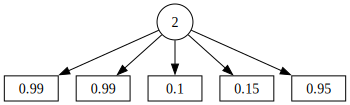

In [29]:
#| caption: Decision tree in a `DecisionTreeFactor`.
#| label: fig:decision_tree_factor
show(conductivity_false_factor)

### Enumerate and DiscreteValues

Above we also used the `enumerate` method:
```python
enumerate(self: gtsam.DecisionTreeFactor) -> List[Tuple[gtsam::DiscreteValues, float]]
```

{raw:tex}`\noindent`
which yields a list of `DiscreteValues` assignments and the factor value corresponding to that assignment. E.g.:

In [30]:
conductivity_false_factor.enumerate()

[(DiscreteValues{2: 0}, 0.99),
 (DiscreteValues{2: 1}, 0.99),
 (DiscreteValues{2: 2}, 0.1),
 (DiscreteValues{2: 3}, 0.15),
 (DiscreteValues{2: 4}, 0.95)]

We have discussed the `DiscreteValues` type above in detail in Section 2.3.

### Conditional and Factor Products
Discrete conditionals and factors support multiplication by overloading the `*` operator. There are some rules, though:
1. conditional * conditional -> conditional
2. factor * conditional -> factor
3. conditional * factor: not allowed!

We used (1) to create joint distributions, and (2) to implement Bayes’ theorem. Option (3) is currently not allowed in GTSAM and will throw an error.